# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_1.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:41:10,305] A new study created in memory with name: KNN
[I 2024-08-26 01:41:22,007] Trial 0 finished with value: 0.4980095606319702 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 0 with value: 0.4980095606319702.
[I 2024-08-26 01:41:52,993] Trial 1 finished with value: 0.5031453540414944 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 91}. Best is trial 1 with value: 0.5031453540414944.
[I 2024-08-26 01:41:57,422] Trial 2 finished with value: 0.7140649724649312 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'auto', 'leaf_size': 31}. Best is trial 2 with value: 0.7140649724649312.
[I 2024-08-26 01:42:24,877] Trial 3 finished with value: 0.4980095606319702 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'euclidean', 'p'

[I 2024-08-26 01:48:40,306] Trial 32 finished with value: 0.5575667190520958 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 25}. Best is trial 29 with value: 0.7274751753815489.
[I 2024-08-26 01:48:43,956] Trial 33 finished with value: 0.7251261811161467 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 22, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 29 with value: 0.7274751753815489.
[I 2024-08-26 01:49:00,246] Trial 34 finished with value: 0.522802194480857 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 29 with value: 0.7274751753815489.
[I 2024-08-26 01:49:20,989] Trial 35 finished with value: 0.5089315479872848 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'minkowski', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 29

[I 2024-08-26 01:57:07,235] Trial 64 finished with value: 0.5628624876454117 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 01:57:09,279] Trial 65 finished with value: 0.6870385337947168 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 66}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 01:57:30,039] Trial 66 finished with value: 0.7787834843681012 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 90}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 01:57:33,946] Trial 67 finished with value: 0.5137597611069478 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 58}. Best is trial 41 

[I 2024-08-26 02:03:29,123] Trial 96 finished with value: 0.6865000514551798 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 02:03:32,349] Trial 97 finished with value: 0.5475235582699839 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 61}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 02:03:34,753] Trial 98 finished with value: 0.6280946261793665 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 97}. Best is trial 41 with value: 0.7787834843681012.
[I 2024-08-26 02:03:53,715] Trial 99 finished with value: 0.5628624876454117 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 4

In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 41
Best accuracy: 0.7787834843681012
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 7}


              precision    recall  f1-score   support

           0     0.6494    1.0000    0.7874        50
           1     1.0000    0.4600    0.6301        50

    accuracy                         0.7300       100
   macro avg     0.8247    0.7300    0.7088       100
weighted avg     0.8247    0.7300    0.7088       100



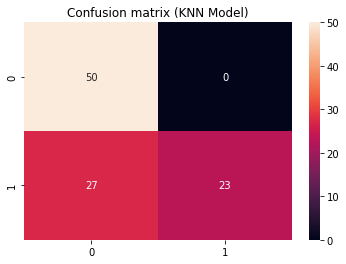

In [36]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.7300
Precision: 1.0000
Recall: 0.4600
F1 Score: 0.6301

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



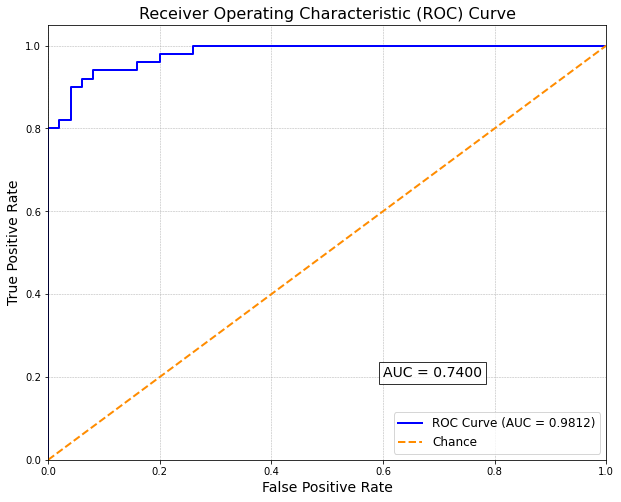

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [12]:
# Creating and running our optimization
study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 02:03:54,066] A new study created in memory with name: logr
[I 2024-08-26 02:04:31,632] Trial 0 finished with value: 0.4819614709464114 and parameters: {'C': 0.009130376600876015, 'solver': 'newton-cg', 'max_iter': 725}. Best is trial 0 with value: 0.4819614709464114.
[I 2024-08-26 02:05:53,038] Trial 1 finished with value: 0.3414351972711123 and parameters: {'C': 9.355593843007206, 'solver': 'sag', 'max_iter': 795}. Best is trial 0 with value: 0.4819614709464114.
[I 2024-08-26 02:06:35,397] Trial 2 finished with value: 0.4816430655139605 and parameters: {'C': 0.0311725891939038, 'solver': 'newton-cg', 'max_iter': 600}. Best is trial 0 with value: 0.4819614709464114.
[I 2024-08-26 02:07:35,170] Trial 3 finished with value: 0.37891088681022145 and parameters: {'C': 0.6989510965620347, 'solver': 'sag', 'max_iter': 583}. Best is trial 0 with value: 0.4819614709464114.
[I 2024-08-26 02:09:09,866] Trial 4 finished with value: 0.3392847446152065 and parameters: {'C': 0.09196799

[I 2024-08-26 02:17:43,284] Trial 39 finished with value: 0.4496694011965563 and parameters: {'C': 0.001034323699971337, 'solver': 'liblinear', 'max_iter': 927}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:18:39,304] Trial 40 finished with value: 0.38596086419259584 and parameters: {'C': 0.005103810228484628, 'solver': 'sag', 'max_iter': 562}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:18:45,734] Trial 41 finished with value: 0.4819478118789954 and parameters: {'C': 0.00598917549111398, 'solver': 'newton-cg', 'max_iter': 829}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:18:52,132] Trial 42 finished with value: 0.48192205081292655 and parameters: {'C': 0.011836544803444704, 'solver': 'newton-cg', 'max_iter': 904}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:18:58,513] Trial 43 finished with value: 0.4817080248623464 and parameters: {'C': 0.025783158911866944, 'solver': 'newton-cg', 'max_iter': 756}.

[I 2024-08-26 02:25:43,077] Trial 79 finished with value: 0.48167817420313985 and parameters: {'C': 0.003944411972790128, 'solver': 'newton-cg', 'max_iter': 771}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:25:50,018] Trial 80 finished with value: 0.48181385179910696 and parameters: {'C': 0.01465401736267739, 'solver': 'newton-cg', 'max_iter': 824}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:25:56,775] Trial 81 finished with value: 0.48198106129858753 and parameters: {'C': 0.006854401767308856, 'solver': 'newton-cg', 'max_iter': 784}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:26:04,169] Trial 82 finished with value: 0.48189785378036454 and parameters: {'C': 0.01284231794290376, 'solver': 'newton-cg', 'max_iter': 777}. Best is trial 13 with value: 0.4820457587976851.
[I 2024-08-26 02:26:10,938] Trial 83 finished with value: 0.48202925058684676 and parameters: {'C': 0.006479995466244241, 'solver': 'newton-cg', 'max_iter

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 13
Best accuracy: 0.4820457587976851
Best hyperparameters: {'C': 0.00675481136468921, 'solver': 'newton-cg', 'max_iter': 729}


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



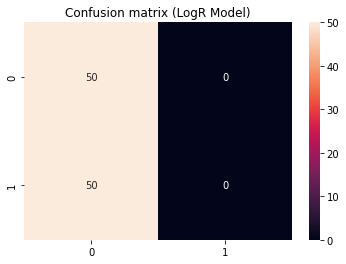

In [14]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



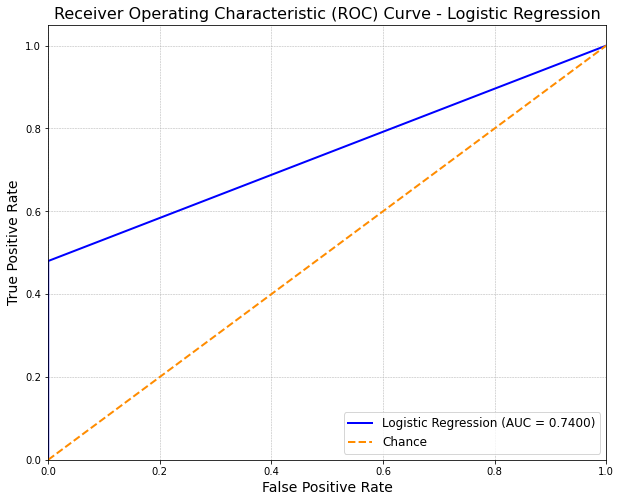

In [53]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 02:30:35,242] A new study created in memory with name: Dect
[I 2024-08-26 02:30:36,933] Trial 0 finished with value: 0.2521321812976618 and parameters: {'max_depth': 42, 'ccp_alpha': 0.7496880784542163, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 0 with value: 0.2521321812976618.
[I 2024-08-26 02:30:38,636] Trial 1 finished with value: 0.2521321812976618 and parameters: {'max_depth': 52, 'ccp_alpha': 6.127830786955587, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.2521321812976618.
[I 2024-08-26 02:30:40,337] Trial 2 finished with value: 0.49745400795859523 and parameters: {'max_depth': 17, 'ccp_alpha': 0.09172663684833246, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 2 with value: 0.49745400795859523.
[I 2024-08-26 02:30:42,023] Trial 3 finished with value: 

[I 2024-08-26 02:31:27,023] Trial 29 finished with value: 0.2521321812976618 and parameters: {'max_depth': 24, 'ccp_alpha': 2.9616913582937863, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 12 with value: 0.6167321261411584.
[I 2024-08-26 02:31:28,818] Trial 30 finished with value: 0.5046068527819505 and parameters: {'max_depth': 18, 'ccp_alpha': 0.010494907072267537, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 12 with value: 0.6167321261411584.
[I 2024-08-26 02:31:30,686] Trial 31 finished with value: 0.6137617567298738 and parameters: {'max_depth': 27, 'ccp_alpha': 0.0010267457235939724, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 12 with value: 0.6167321261411584.
[I 2024-08-26 02:31:32,550] Trial 32 finished with value: 0.5774655833089745 and parameters: {'max_depth': 45, 'ccp_alpha': 0.0016790

[I 2024-08-26 02:32:18,776] Trial 58 finished with value: 0.5773552915249225 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0032250730278819296, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:32:20,603] Trial 59 finished with value: 0.6724100576709175 and parameters: {'max_depth': 38, 'ccp_alpha': 0.001422951374063732, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:32:22,403] Trial 60 finished with value: 0.673927257104289 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0013370552390178844, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:32:24,194] Trial 61 finished with value: 0.6254096922093756 and parameters: {'max_depth': 37, 'ccp_alpha':

[I 2024-08-26 02:33:11,337] Trial 87 finished with value: 0.6085796443031696 and parameters: {'max_depth': 23, 'ccp_alpha': 0.0028014607838692065, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:33:13,160] Trial 88 finished with value: 0.5570015017219745 and parameters: {'max_depth': 26, 'ccp_alpha': 0.0043132466385111335, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:33:15,091] Trial 89 finished with value: 0.6947308082098015 and parameters: {'max_depth': 25, 'ccp_alpha': 0.0012937065796653476, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 51 with value: 0.7237249235713655.
[I 2024-08-26 02:33:16,915] Trial 90 finished with value: 0.6492485796563164 and parameters: {'max_depth': 17, 'ccp_alpha'

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 95
Best accuracy: 0.735731854628819
Best hyperparameters: {'max_depth': 22, 'ccp_alpha': 0.0010089072108102686, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



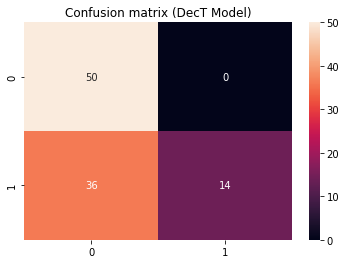

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.5900
Precision: 1.0000
Recall: 0.1800
F1 Score: 0.3051

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        50
           1       1.00      0.18      0.31        50

    accuracy                           0.59       100
   macro avg       0.77      0.59      0.51       100
weighted avg       0.77      0.59      0.51       100



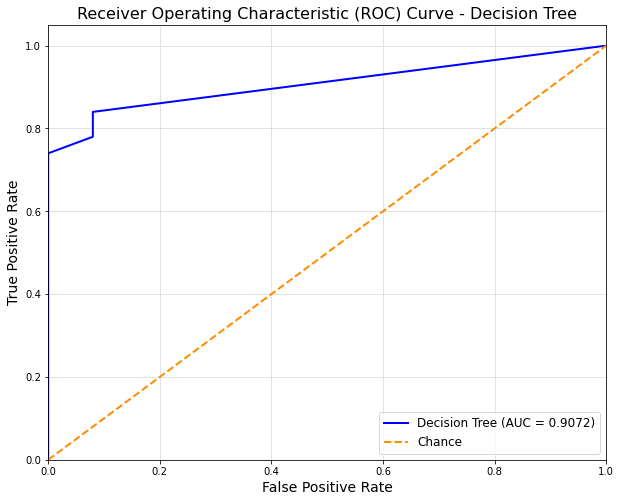

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=20)

[I 2024-08-26 02:33:33,713] A new study created in memory with name: SVM
[I 2024-08-26 02:44:46,753] Trial 0 finished with value: 0.5373862480340512 and parameters: {'C': 7.512194892141294, 'gamma': 0.010369433423686463}. Best is trial 0 with value: 0.5373862480340512.
[I 2024-08-26 02:57:25,197] Trial 1 finished with value: 0.5197659508983565 and parameters: {'C': 0.14679665750615484, 'gamma': 0.023528986569997096}. Best is trial 0 with value: 0.5373862480340512.
[I 2024-08-26 03:26:55,826] Trial 2 finished with value: 0.2521321812976618 and parameters: {'C': 0.0014733347146498033, 'gamma': 2.9755962232731637e-05}. Best is trial 0 with value: 0.5373862480340512.
[I 2024-08-26 03:48:41,607] Trial 3 finished with value: 0.4805442120669279 and parameters: {'C': 0.005260919806972874, 'gamma': 0.0029427807812963695}. Best is trial 0 with value: 0.5373862480340512.
[I 2024-08-26 04:01:00,285] Trial 4 finished with value: 0.5192586552804843 and parameters: {'C': 1.5804628019220506, 'gamma': 

[I 2024-08-26 08:16:08,020] Trial 41 finished with value: 0.873716511935268 and parameters: {'C': 23.390109293978536, 'gamma': 0.09858581958070052}. Best is trial 17 with value: 0.8748878428823431.
[I 2024-08-26 08:24:32,517] Trial 42 finished with value: 0.5691065350722078 and parameters: {'C': 34.70654321078194, 'gamma': 0.01712756645487728}. Best is trial 17 with value: 0.8748878428823431.
[I 2024-08-26 08:26:04,940] Trial 43 finished with value: 0.8615414469662177 and parameters: {'C': 5.675929028856343, 'gamma': 0.12083199361312227}. Best is trial 17 with value: 0.8748878428823431.
[I 2024-08-26 08:48:49,751] Trial 44 finished with value: 0.4778081684849835 and parameters: {'C': 0.9183343173208248, 'gamma': 1.2417302268522063e-05}. Best is trial 17 with value: 0.8748878428823431.
[I 2024-08-26 08:50:00,590] Trial 45 finished with value: 0.8209563559501604 and parameters: {'C': 218.75649593388164, 'gamma': 0.3779363719780323}. Best is trial 17 with value: 0.8748878428823431.
[I 202

[I 2024-08-26 11:38:24,906] Trial 83 finished with value: 0.6194067052458456 and parameters: {'C': 764.990585626503, 'gamma': 0.012978631652704044}. Best is trial 81 with value: 0.875475788642293.
[I 2024-08-26 11:41:41,730] Trial 84 finished with value: 0.8718629115453486 and parameters: {'C': 983.9063647689201, 'gamma': 0.03568330891720541}. Best is trial 81 with value: 0.875475788642293.
[I 2024-08-26 11:48:16,477] Trial 85 finished with value: 0.7246443774029924 and parameters: {'C': 426.169031380295, 'gamma': 0.02129429290936043}. Best is trial 81 with value: 0.875475788642293.
[I 2024-08-26 11:52:33,136] Trial 86 finished with value: 0.7752138264043347 and parameters: {'C': 239.33729537259444, 'gamma': 0.02977987446894492}. Best is trial 81 with value: 0.875475788642293.
[I 2024-08-26 11:55:23,360] Trial 87 finished with value: 0.8733651686567824 and parameters: {'C': 766.0141536547412, 'gamma': 0.040050776874754834}. Best is trial 81 with value: 0.875475788642293.
[I 2024-08-26 

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 93
Best accuracy: 0.876473412869336
Best hyperparameters: {'C': 235.38916872950816, 'gamma': 0.06318251950383921}


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



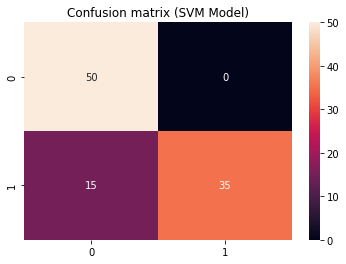

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8500
Precision: 1.0000
Recall: 0.7000
F1 Score: 0.8235

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



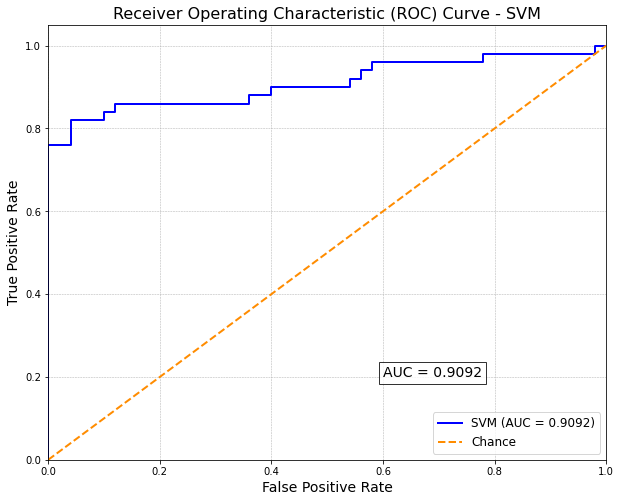

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.007992365501610402

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 12:42:41,126] A new study created in memory with name: XGBoost
[I 2024-08-26 12:47:35,936] Trial 6 finished with value: 0.8459615555558456 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.524427750257078, 'colsample_bytree': 0.9481558241437489, 'reg_alpha': 6.420763070947774e-05, 'reg_lambda': 0.41723284567197866}. Best is trial 6 with value: 0.8459615555558456.
[I 2024-08-26 12:48:53,089] Trial 2 finished with value: 0.910443840521945 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7590811048243845, 'colsample_bytree': 0.697660918472949, 'reg_alpha': 0.003775859902904679, 'reg_lambda': 2.4296450127192966}. Best is trial 2 with value: 0.910443840521945.
[I 2024-08-26 12:50:07,478] Trial 5 finished with value: 0.9163553197772342 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9398043044133153, 'colsample_bytree': 0.8358558357232378, 'reg_alpha': 0.00043771016000294195, 'reg_lambda': 0.13318325864128755}. 

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 14
Best accuracy: 0.9209222533149418
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.8285929713946516, 'colsample_bytree': 0.8988802222007553, 'reg_alpha': 1.7223178144028494e-05, 'reg_lambda': 0.002840150586884481}


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



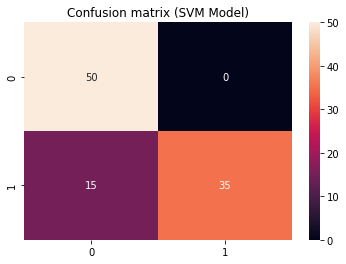

In [35]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")


Accuracy: 0.8500
Precision: 1.0000
Recall: 0.7000
F1 Score: 0.8235

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



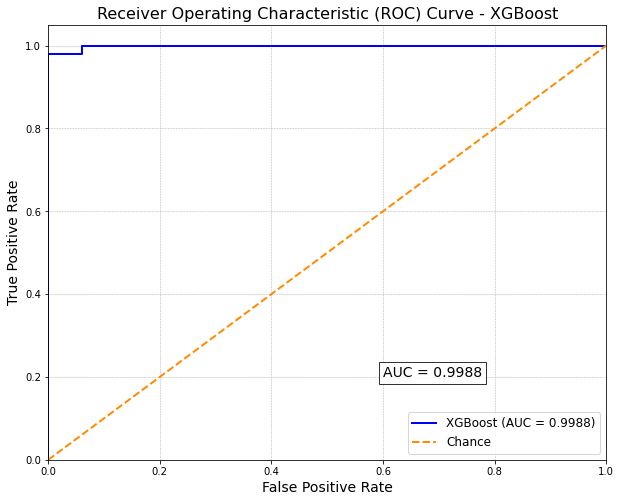

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [58]:


# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.73,0.46,1.0,0.630137,0.9812
1,SVM,0.85,0.70,1.0,0.823529,0.9092
2,LR,0.50,0.00,0.0,0.000000,0.7400
3,DecT,0.59,0.18,1.0,0.305085,0.9072
4,XGB,0.85,0.70,1.0,0.823529,0.9988


In [59]:
metrics_df.to_excel('result/1.xlsx', index=False)

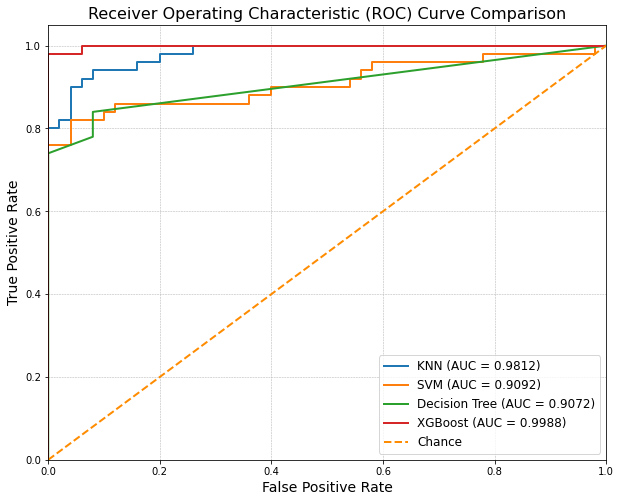

In [47]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
